# Supplemental figures for national attribution paper
#### Christopher Callahan
#### Christopher.W.Callahan.GR@dartmouth.edu

#### Mechanics
Dependencies

In [1]:
import xarray as xr
import numpy as np
import sys
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
from matplotlib import rcParams
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import seaborn as sns
from rasterio import features
from affine import Affine
import geopandas as gp
import descartes
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from scipy import stats
import cartopy as cart

Data locations

In [2]:
loc_emissions = "../Data/Emissions/"
loc_emissions_shares = "../Data/Emissions/Shares/"
loc_shp = "../Data/CountryShapefile/"
loc_panel = "../Data/Panel/"
loc_fair_gmst = "../Data/FAIR/GMST/"
loc_damages_processed = "../Data/Damages/Processed/"
loc_damages_country = "../Data/Damages/Country-Attributed/"
loc_damagefunc = "../Data/DamageFunction/"
loc_cmip6_hist_gmst = "../Data/CMIP6/GMST/Historical/"
loc_cmip6_histnat_gmst = "../Data/CMIP6/GMST/HistoricalNat/"
loc_cesm_hist_gmst = "../Data/CESM1-LE/GMST/Historical/"
loc_cesm_histnat_gmst = "../Data/CESM1-LE/GMST/HistoricalNat/"

Shapefile

In [3]:
shp = gp.read_file(loc_shp)
iso_shp = shp.ISO3.values

Plotting function

In [4]:
def add_country_geometries(input_vals,iso_vals,iso_plot,shapefile,shapefile_iso_name,cbar):
    for i in iso_plot:
        if i in iso_vals:
            val = input_vals.loc[i].values
            if (~np.isnan(val)):
                ax.add_geometries(shapefile.loc[shapefile[shapefile_iso_name].values==i,"geometry"],ccrs.PlateCarree(),
                                  facecolor=cbar.to_rgba(val),edgecolor="black",linewidth=0.5)
            else:
                ax.add_geometries(shapefile.loc[shapefile[shapefile_iso_name].values==i,"geometry"],ccrs.PlateCarree(),
                                  facecolor=[0.95,0.95,0.95],edgecolor="black",linewidth=0.5)
        else:
            ax.add_geometries(shapefile.loc[shapefile[shapefile_iso_name].values==i,"geometry"],ccrs.PlateCarree(),
                              facecolor=[0.95,0.95,0.95],edgecolor="black",linewidth=0.5)
def add_attr_geometries(input_vals,iso_vals,iso_plot,shapefile,shapefile_iso_name,cbar):
    for i in iso_plot:
        if i in iso_vals:
            val = input_vals.loc[i].values
            if (~np.isnan(val))&(np.abs(val)!=0):
                ax.add_geometries(shapefile.loc[shapefile[shapefile_iso_name].values==i,"geometry"],ccrs.PlateCarree(),
                                  facecolor=cbar.to_rgba(val),edgecolor="black",linewidth=0.5)
            elif (~np.isnan(val))&(np.abs(val)==0):
                ax.add_geometries(shapefile.loc[shapefile[shapefile_iso_name].values==i,"geometry"],ccrs.PlateCarree(),
                                  facecolor=[0.95,0.95,0.95],edgecolor="black",linewidth=0.5)
            elif (np.isnan(val)):
                ax.add_geometries(shapefile.loc[shapefile[shapefile_iso_name].values==i,"geometry"],ccrs.PlateCarree(),
                                  facecolor=[0.95,0.95,0.95],edgecolor="black",linewidth=0.5)
        else:
            ax.add_geometries(shapefile.loc[shapefile[shapefile_iso_name].values==i,"geometry"],ccrs.PlateCarree(),
                              facecolor=[0.95,0.95,0.95],edgecolor="black",linewidth=0.5)

#### Analysis/plotting

Rankings of damages

/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/ipykernel_launcher.py:96: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


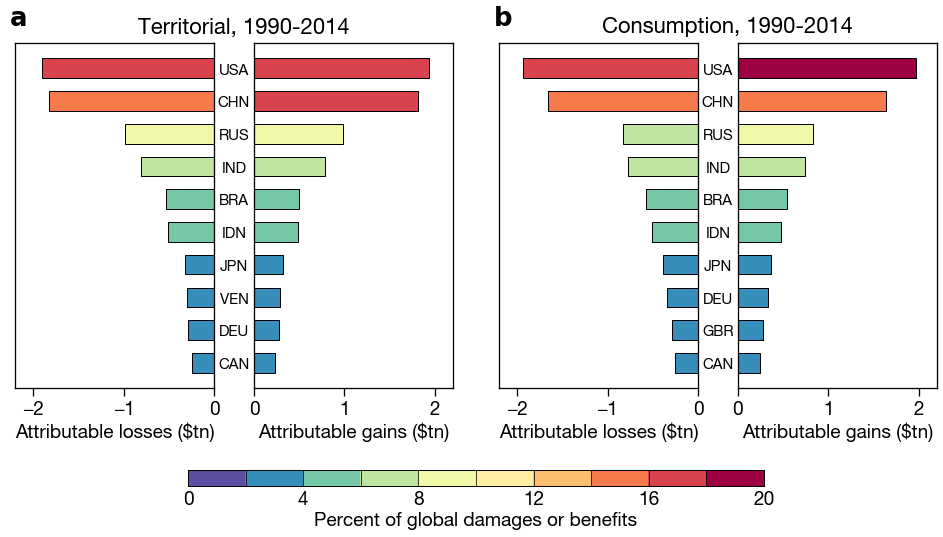

In [12]:
fig = plt.figure(figsize=(16,8))

rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 19.0

tfs = 22
n_bar = 10
a1 = 1
a2 = 0.7

for j in [0,1]:
    gs2 = gridspec.GridSpec(1,2)
    if j == 0:
        gs2.update(left=0.1,right=0.48,top=0.9,bottom=0.3,wspace=0.2,hspace=0.2)
        accounting = "territorial"
        y1 = 1990
        y2 = 2014
        damagefunc = "BHMSR"
    else:
        gs2 = gridspec.GridSpec(1,2)
        gs2.update(left=0.52,right=0.9,top=0.9,bottom=0.3,wspace=0.2,hspace=0.2)
        accounting = "consumption"
        y1 = 1990
        y2 = 2014
        damagefunc = "BHMSR"
        
    # get data and rank by net losses    
    fname_str = damagefunc+"_"+accounting+"_shares"+str(y1)+"-"+str(y2)+"_"+str(y1)+"-"+str(y2)
    losses = xr.open_dataset(loc_damages_processed+"global_attributable_benefits_losses_"+fname_str+".nc").attributable_losses.sum(dim="time")/1e12
    benefits = xr.open_dataset(loc_damages_processed+"global_attributable_benefits_losses_"+fname_str+".nc").attributable_benefits.sum(dim="time")/1e12
    
    df = pd.DataFrame({"iso":losses.iso_attr,"losses":losses,"benefits":benefits})
    df["losses_share"] = 100*df["losses"]/(np.sum(df.losses.values))
    df["benefits_share"] = 100*df["benefits"]/(np.sum(df.benefits.values))
    
    df_sort = df.sort_values(by="losses",ascending=True)
    df_sort_final = df_sort.iloc[0:n_bar,:]
    if j == 0:
        df_sort_terr = df_sort_final
    else:
        df_sort_cons = df_sort_final
    
    vmin = 0
    vmax = 20
    norm = colors.Normalize(vmin=vmin,vmax=vmax) 
    ncol = 10
    cmap = "Spectral_r"
    cbar = plt.cm.ScalarMappable(norm=norm,cmap=plt.cm.get_cmap(cmap,(ncol)))
    
    for k in [0,1]:
        rcParams["axes.linewidth"] = 1.3
        rcParams['xtick.major.size'] = 8
        rcParams['xtick.major.width'] = 1.3
        rcParams['ytick.major.size'] = 8
        rcParams['ytick.major.width'] = 1.3

        ax = plt.subplot(gs2[0,k])
        
        y = np.flip(np.arange(1,n_bar+1,1))
        hgt = 0.6
        
        if k == 0:
            
            cols = [cbar.to_rgba(x) for x in df_sort_final.losses_share.values]
            plt.barh(y,df_sort_final.losses.values,edgecolor="black",
                    color=cols,height=hgt)
            
            plt.xlim([-2.2,0])
            plt.xlabel("Attributable losses ($tn)")
            plt.yticks([])
            
        else:

            cols = [cbar.to_rgba(x) for x in df_sort_final.benefits_share.values]
            plt.barh(y,df_sort_final.benefits.values,edgecolor="black",
                    color=cols,height=hgt)
            
            plt.xlim([0,2.2])
            plt.xlabel("Attributable gains ($tn)")
            plt.yticks(ticks=y,labels=df_sort_final.iso.values)
            ax.tick_params(axis="y",labelsize=15,length=0,pad=20)
            for tick in ax.yaxis.get_majorticklabels():
                tick.set_horizontalalignment("center")
    
            plt.title(accounting.title()+", "+str(y1)+"-"+str(y2),
                     fontsize=tfs,x=-0.05,pad=10)
    
    l = 0.25
    b = 0.13
    w = 0.5
    h = 0.028
    
    labelfs = 19
    rcParams["axes.linewidth"] = 1.0
    cbar_ax = fig.add_axes([l,b,w,h])
    cb = fig.colorbar(cbar,cax=cbar_ax,orientation="horizontal",
                      drawedges=True,extend="neither",
                      ticks=[0,4,8,12,16,20])
    cbar_ax.tick_params(direction="in",width=0.05,labelsize=labelfs)
    cb.set_label("Percent of global damages or benefits",fontsize=labelfs)
    
    
    
plt.figtext(0.095,0.93,r'$\bf{a}$',fontsize=26)
plt.figtext(0.515,0.93,r'$\bf{b}$',fontsize=26)

plt.savefig("../Figures/FigX_Ranks.pdf")
plt.show()

In [13]:
df_sort_terr

,iso,losses,benefits,losses_share,benefits_share
154,USA,-1.908117,1.938370,16.523488,17.910617
22,CHN,-1.829020,1.815349,15.838546,16.773900
128,RUS,-0.986020,0.980911,8.538516,9.063663
64,IND,-0.809420,0.780602,7.009238,7.212799
13,BRA,-0.527991,0.502674,4.572184,4.644732
165,IDN,-0.513532,0.489037,4.446968,4.518720
70,JPN,-0.327658,0.315736,2.837378,2.917410
158,VEN,-0.301894,0.283133,2.614272,2.616162
54,DEU,-0.292272,0.282088,2.530954,2.606508
16,CAN,-0.246835,0.234787,2.137489,2.169446


In [14]:
df_sort_cons

,iso,losses,benefits,losses_share,benefits_share
154,USA,-1.937286,1.965654,17.672756,19.024804
22,CHN,-1.660085,1.643267,15.144011,15.904540
128,RUS,-0.834099,0.828983,7.609006,8.023401
64,IND,-0.772943,0.746278,7.051117,7.222938
13,BRA,-0.570124,0.544924,5.200919,5.274110
165,IDN,-0.506829,0.482662,4.623515,4.671501
70,JPN,-0.385285,0.371780,3.514740,3.598314
54,DEU,-0.341476,0.329946,3.115093,3.193420
152,GBR,-0.285193,0.274748,2.601658,2.659176
16,CAN,-0.251894,0.240114,2.297884,2.323975


In [15]:
print(df_sort_terr.losses_share.sum())
print(df_sort_terr.benefits_share.sum())

67.04903451132019
70.43395558219679


In [16]:
print(df_sort_cons.losses_share.sum())
print(df_sort_cons.benefits_share.sum())

68.83069903767792
71.8961787097968


US attributable damages in two different climate model ensembles

In [17]:
import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning,message="Mean of empty")

In [18]:
country_to_attr = "USA"
y1 = 1990
y2 = 2014
accounting = "territorial"
damagefunc = "BHMSR"
fname_str = damagefunc+"_"+accounting+"_shares"+str(y1)+"-"+str(y2)+"_"+str(y2)
files_list = [x for x in os.listdir(loc_damages_country+country_to_attr+"/") if ("global" not in x)&(fname_str in x)&("fulldist" in x)]
isos_attr = [x[15:18] for x in files_list]

print("this chunk and the following figure chunk will not work because the underlying data was too large to share on github. if you would like access to this data please contact the authors!")
sys.exit()

for i in isos_attr:
    if np.mod(isos_attr.index(i),10)==0:
        print(isos_attr.index(i))
    fname = country_to_attr+"-attributed_"+i+"_gdp_damages_fulldist_"+fname_str+".nc"
    damage_to_country = xr.open_dataset(loc_damages_country+country_to_attr+"/"+fname)
    if i == isos_attr[0]:
        damages_mean_cesm = damage_to_country.pct_damage.loc[:,"CESM1-SFLE",:,:,:].mean(dim=["member","fair_run","boot"])
        damages_mean_cmip = damage_to_country.pct_damage.loc[:,"CMIP6",:,:,:].mean(dim=["member","fair_run","boot"])
    else:
        damages_mean_cesm = xr.concat([damages_mean_cesm,damage_to_country.pct_damage.loc[:,"CESM1-SFLE",:,:,:].mean(dim=["member","fair_run","boot"])],dim="iso")
        damages_mean_cmip = xr.concat([damages_mean_cmip,damage_to_country.pct_damage.loc[:,"CMIP6",:,:,:].mean(dim=["member","fair_run","boot"])],dim="iso")

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


Plot both

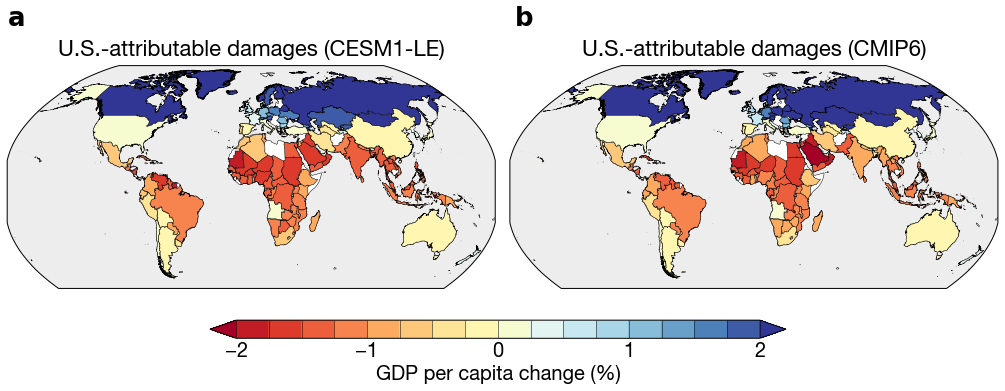

In [21]:
fig = plt.figure(figsize=(16,7))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 20.0
rcParams["axes.linewidth"] = 1
rcParams['xtick.major.size'] = 4
rcParams['xtick.major.width'] = 1
rcParams['ytick.major.size'] = 4
rcParams['ytick.major.width'] = 1

tfs = 22

gs1 = gridspec.GridSpec(1,2)
gs1.update(left=0.1,right=0.96,top=0.9,bottom=0.2,wspace=0.03,hspace=0.2)


cmin = -2
cmax = 2
nrange = 17
bounds = np.linspace(cmin,cmax,nrange)
cols = plt.get_cmap('RdYlBu')(np.linspace(0,1,len(bounds)+1))
cmap = colors.ListedColormap(cols[1:-1])
cmap.set_over(cols[-1])
cmap.set_under(cols[0])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=len(bounds)-1)
cbar = plt.cm.ScalarMappable(norm=norm,cmap=cmap)

for k in [0,1]:
    if k == 0:
        damages_mean = damages_mean_cesm
        ttl = "CESM1-LE"
    else:
        damages_mean = damages_mean_cmip
        ttl = "CMIP6"
        
    ax = plt.subplot(gs1[0,k],projection=ccrs.Robinson())
    ax.set_extent([-180,180,-63,90],crs=ccrs.PlateCarree())
    ax.coastlines(linewidth=0.5)
    ax.add_feature(cart.feature.OCEAN, edgecolor="white",facecolor=[0.93,0.93,0.93])

    for i in damages_mean.iso.values:
        if i in iso_shp:
            val = damages_mean.loc[i].values
            p_val = 0 #p.loc[i].values
            if ((~np.isnan(val)) & (p_val < 0.05)):
                    ax.add_geometries(shp.loc[shp["ISO3"].values==i,"geometry"],ccrs.PlateCarree(),
                                      facecolor=cbar.to_rgba(val),edgecolor="black",linewidth=0.5)
            elif ((~np.isnan(val)) & (p_val >= 0.05)):
                ax.add_geometries(shp.loc[shp["ISO3"].values==i,"geometry"],ccrs.PlateCarree(),
                                      facecolor=cbar.to_rgba(val),edgecolor="black",linewidth=0.5,
                                 hatch="///")
            else:
                ax.add_geometries(shp.loc[shp["ISO3"].values==i,"geometry"],ccrs.PlateCarree(),
                                      facecolor=[0.95,0.95,0.95],edgecolor="black",linewidth=0.5)
        else:
            ax.add_geometries(shp.loc[shp["ISO3"].values==i,"geometry"],ccrs.PlateCarree(),
                                  facecolor=[0.95,0.95,0.95],edgecolor="black",linewidth=0.5)
    
    plt.title("U.S.-attributable damages ("+ttl+")",pad=10,fontsize=tfs)

    
## colorbar
l = 0.276
b = 0.23
w = 0.5
h = 0.036
cbar_ax = fig.add_axes([l,b,w,h])
cb = fig.colorbar(cbar,cax=cbar_ax,orientation="horizontal",
                  drawedges=True,extend="both",
                 ticks=[-3,-2,-1,0,1,2,3])
cbar_ax.tick_params(direction="in",width=0.05)
cb.set_label("GDP per capita change (%)")

plt.figtext(0.1,0.85,r'$\bf{a}$',fontsize=26)
plt.figtext(0.54,0.85,r'$\bf{b}$',fontsize=26)

plt.savefig("../Figures/FigX_US_Damages_CESM_CMIP6.png")
plt.show()

Now the long run vs short run damages

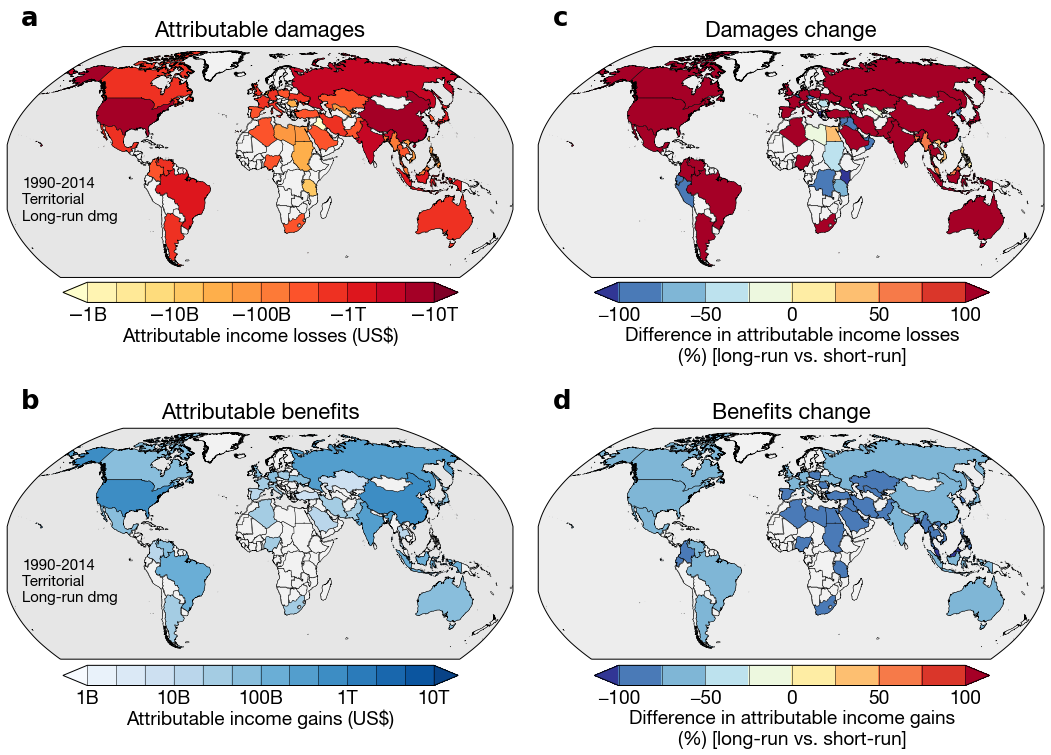

In [20]:
fig = plt.figure(figsize=(18,14))

rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 19.0

gs1 = gridspec.GridSpec(2,2)
gs1.update(left=0.1,right=0.9,top=0.9,bottom=0.23,wspace=0.05,hspace=0.3)

tfs = 22

# colorbar positions
left = [0.143,0.553]
bottom1 = 0.615
bottom2 = 0.235
width = 0.305
height = 0.02
tks = [1e9,1e10,1e11,1e12,1e13]
lbs1 = [r"$\rm{-}$1B",r"$\rm{-}$10B",r"$\rm{-}$100B",\
        r"$\rm{-}$1T",r"$\rm{-}$10T"]
lbs2 = ["1B","10B","100B","1T","10T"]

# details for maps of damages changes
#change_ext = ["both"]
#change_min = [-]
#change_max = [20,500]
#change_ncol = [9,11]
#change_maps = ["RdYlBu_r","YlOrRd"]

accounting_loop = ["territorial","territorial"]
y1_loop = [1990,1990]
y2 = 2014
#titles = ["Net damages","Net damages","Net damages"]
damagefunc_loop = ["BHMLR","BHMLR"]


# loop through accounting/y1/etc.
for j in np.arange(0,len(accounting_loop),1):
    if j == 0:
        rcParams["axes.linewidth"] = 1
        rcParams['xtick.major.size'] = 4
        rcParams['xtick.major.width'] = 1
        rcParams['ytick.major.size'] = 4
        rcParams['ytick.major.width'] = 1
        
        fname_str = damagefunc_loop[j]+"_"+accounting_loop[j]+"_shares"+str(y1_loop[j])+"-"+str(y2)+"_"+str(y1_loop[j])+"-"+str(y2)
        damages_processed = xr.open_dataset(loc_damages_processed+"global_attributable_benefits_losses_"+fname_str+".nc")
        attr_benefits = damages_processed.attributable_benefits.sum(dim="time")
        attr_losses = damages_processed.attributable_losses.sum(dim="time")*-1
        
        # losses
        ax = plt.subplot(gs1[0,0],projection=ccrs.Robinson())
        vmin = 1e9
        vmax = 1e13
        ncol = 13
        bounds = np.linspace(vmin,vmax,ncol)

        cols = plt.get_cmap('YlOrRd')(np.linspace(0,1,len(bounds)+1))
        cm = colors.ListedColormap(cols[1:-1])
        cm.set_over(cols[-1])
        cm.set_under(cols[0])
        norm = colors.SymLogNorm(linthresh=1e3,vmin=vmin,vmax=vmax)
        cbar = plt.cm.ScalarMappable(norm=norm,cmap=cm)
    
        plt.setp(ax.spines.values(), linewidth=1)
        ax.set_extent([-180,180,-63,90],crs=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.5)
        ax.add_feature(cart.feature.OCEAN, edgecolor="white",facecolor=[0.9,0.9,0.9])
        
        # add colors/geoms
        add_attr_geometries(attr_losses,iso_shp,attr_losses.iso_attr.values,shp,"ISO3",cbar)
        
        plt.title("Attributable damages",fontsize=tfs,pad=10)
        
        if damagefunc_loop[j] == "BHMSR":
            funcstr = "Short-run dmg"
        elif damagefunc_loop[j] == "BHMLR":
            funcstr = "Long-run dmg"
        st = str(y1_loop[j])+"-"+str(y2)+"\n"+accounting_loop[j].title()+"\n"+funcstr
        plt.text(0.03,0.25,st,ha="left",fontsize=15,
                transform=ax.transAxes)
        
        # colorbar
        cbar_ax = fig.add_axes([left[j], bottom1, width, height])
        cb = fig.colorbar(cbar,cax=cbar_ax,orientation='horizontal',drawedges=True,
                          extend="both",ticks=tks,extendfrac=0.07)
        cbar_ax.tick_params(direction="in",width=0.05)
        cb.ax.set_xticklabels(lbs1)
        cb.set_label("Attributable income losses (US$)",labelpad=2)
        
        
        # benefits
        ax = plt.subplot(gs1[1,0],projection=ccrs.Robinson())
        
        ncol = 14
        bounds = np.linspace(vmin,vmax,ncol)
        cols = plt.get_cmap('Blues')(np.linspace(0,1,len(bounds)+1))
        cm = colors.ListedColormap(cols[1:-2])
        cm.set_over(cols[-2])
        cm.set_under(cols[0])
        norm = colors.SymLogNorm(linthresh=1e3,vmin=vmin,vmax=vmax)
        cbar = plt.cm.ScalarMappable(norm=norm,cmap=cm)
        
        plt.setp(ax.spines.values(), linewidth=1)
        ax.set_extent([-180,180,-63,90],crs=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.5)
        ax.add_feature(cart.feature.OCEAN, edgecolor="white",facecolor=[0.9,0.9,0.9])

        # add colors/geoms
        add_attr_geometries(attr_benefits,iso_shp,attr_benefits.iso_attr.values,shp,"ISO3",cbar)
        
        plt.title("Attributable benefits",fontsize=tfs,pad=10)
        
        if damagefunc_loop[j] == "BHMSR":
            funcstr = "Short-run dmg"
        elif damagefunc_loop[j] == "BHMLR":
            funcstr = "Long-run dmg"
        st = str(y1_loop[j])+"-"+str(y2)+"\n"+accounting_loop[j].title()+"\n"+funcstr
        plt.text(0.03,0.25,st,ha="left",fontsize=15,
                transform=ax.transAxes)
        
        # colorbar
        cbar_ax = fig.add_axes([left[j], bottom2, width, height])
        cb = fig.colorbar(cbar,cax=cbar_ax,orientation='horizontal',drawedges=True,
                          extend="both",ticks=tks,extendfrac=0.07)
        cbar_ax.tick_params(direction="in",width=0.05)
        cb.ax.set_xticklabels(lbs2)
        cb.set_label("Attributable income gains (US$)",labelpad=2)
        
        
    else:
        # damages and benefits change 
        
        fname_str = damagefunc_loop[j]+"_"+accounting_loop[j]+"_shares"+str(y1_loop[j])+"-"+str(y2)+"_"+str(y1_loop[j])+"-"+str(y2)
        fname_str_orig = "BHMSR_territorial_shares"+str(y1_loop[0])+"-"+str(y2)+"_"+str(y1_loop[0])+"-"+str(y2)
        damages_processed = xr.open_dataset(loc_damages_processed+"global_attributable_benefits_losses_"+fname_str+".nc")
        attr_losses = damages_processed.attributable_losses.sum(dim="time")
        attr_benefits = damages_processed.attributable_benefits.sum(dim="time")
        damages_processed_orig = xr.open_dataset(loc_damages_processed+"global_attributable_benefits_losses_"+fname_str_orig+".nc")
        attr_losses_orig = damages_processed_orig.attributable_losses.sum(dim="time")
        attr_benefits_orig = damages_processed_orig.attributable_benefits.sum(dim="time")
        attr_damages_change1 = 100*(attr_losses - attr_losses_orig)/attr_losses_orig
        attr_benefits_change1 = 100*(attr_benefits - attr_benefits_orig)/attr_benefits_orig
        attr_damages_change = attr_damages_change1.where(~np.isinf(np.abs(attr_damages_change1)),0.0)
        attr_benefits_change = attr_benefits_change1.where(~np.isinf(np.abs(attr_benefits_change1)),0.0)
        if accounting_loop[j]=="consumption":
            benefits_chng = attr_benefits_change
            loss_chng = attr_damages_change
            
        # damages change
        ax = plt.subplot(gs1[0,j],projection=ccrs.Robinson())
        
        plt.setp(ax.spines.values(), linewidth=1)
        ax.set_extent([-180,180,-63,90],crs=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.5)
        ax.add_feature(cart.feature.OCEAN, edgecolor="white",facecolor=[0.93,0.93,0.93])
        
        # colorbar
        vmin = -100
        vmax = 100
        ncol = 9
        bounds = np.linspace(vmin,vmax,ncol)

        cols = plt.get_cmap("RdYlBu_r")(np.linspace(0,1,len(bounds)+1))
        cm = colors.ListedColormap(cols[1:-1])
        cm.set_over(cols[-1])
        cm.set_under(cols[0])
        norm = colors.Normalize(vmin=vmin,vmax=vmax)
        cbar = plt.cm.ScalarMappable(norm=norm,cmap=cm)   
        
        add_attr_geometries(attr_damages_change,iso_shp,attr_damages_change.iso_attr.values,shp,"ISO3",cbar)
        
        
        plt.title("Damages change",fontsize=tfs,pad=10)
        
        #if j == 1:
        #    st = "Consumption"+"\n"+"vs."+"\n"+"territorial"
        #elif j == 2:
        #    st = "1960-2014"+"\n"+"vs."+"\n"+"1990-2014"
        #plt.text(0.12,0.25,st,ha="center",fontsize=15,
        #        transform=ax.transAxes)
    
        cbar_ax = fig.add_axes([left[j], bottom1, width, height])
        cb = fig.colorbar(cbar,cax=cbar_ax,orientation='horizontal',drawedges=True,
                          extend="both",extendfrac=0.07)
        cbar_ax.tick_params(direction="in",width=0.05)
        cb.set_label("Difference in attributable income losses"+"\n"+"(%) [long-run vs. short-run]",
                    labelpad=2)
        
        
        # benefits change
        
        ax = plt.subplot(gs1[1,j],projection=ccrs.Robinson())
        plt.setp(ax.spines.values(), linewidth=1)
        ax.set_extent([-180,180,-63,90],crs=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.5)
        ax.add_feature(cart.feature.OCEAN, edgecolor="white",facecolor=[0.93,0.93,0.93])
        
        add_attr_geometries(attr_benefits_change,iso_shp,attr_benefits_change.iso_attr.values,shp,"ISO3",cbar)
            
        plt.title("Benefits change",fontsize=tfs,pad=10)
        
        #if j == 1:
        #    st = "Consumption"+"\n"+"vs."+"\n"+"territorial"
        #elif j == 2:
        #    st = "1960-2014"+"\n"+"vs."+"\n"+"1990-2014"
        #plt.text(0.12,0.25,st,ha="center",fontsize=15,
        #        transform=ax.transAxes)
        
        cbar_ax = fig.add_axes([left[j], bottom2, width, height])
        cb = fig.colorbar(cbar,cax=cbar_ax,orientation='horizontal',drawedges=True,
                          extend="both",extendfrac=0.07)
        cbar_ax.tick_params(direction="in",width=0.05)
        cb.set_label("Difference in attributable income gains"+"\n"+"(%) [long-run vs. short-run]",
                    labelpad=2)
        
plt.figtext(0.11,0.89,r'$\bf{a}$',fontsize=26)
plt.figtext(0.11,0.51,r'$\bf{b}$',fontsize=26)
plt.figtext(0.52,0.89,r'$\bf{c}$',fontsize=26)
plt.figtext(0.52,0.51,r'$\bf{d}$',fontsize=26)
        
plt.savefig("../Figures/FigX_LongRun.png")
plt.show()

In [23]:
lr_lag_length = 5
coefs_sr = pd.read_csv(loc_damagefunc+"Attribution_TempCoefs_Bootstrap_Contemporaneous.csv",index_col=0)
coefs_lr = pd.read_csv(loc_damagefunc+"Attribution_TempCoefs_Bootstrap_Lag"+str(lr_lag_length)+".csv",index_col=0)
boot = coefs_sr.boot.values
nboot = len(boot)

In [24]:
t_x = np.arange(0,30+1,1)
me_sr = np.zeros((len(t_x),nboot))
me_lr = np.zeros((len(t_x),nboot))
for j in np.arange(0,nboot,1):
    me_sr[:,j] = coefs_sr.coef_t.values[j] + t_x*2*coefs_sr.coef_t2.values[j]
    me_lr[:,j] = coefs_lr.coef_t.values[j] + t_x*2*coefs_lr.coef_t2.values[j]
me_sr_mean = np.mean(me_sr,axis=1)*100
me_sr_upper = np.percentile(me_sr,97.5,axis=1)*100
me_sr_lower = np.percentile(me_sr,2.5,axis=1)*100
me_lr_mean = np.mean(me_lr,axis=1)*100
me_lr_upper = np.percentile(me_lr,97.5,axis=1)*100
me_lr_lower = np.percentile(me_lr,2.5,axis=1)*100

Plot

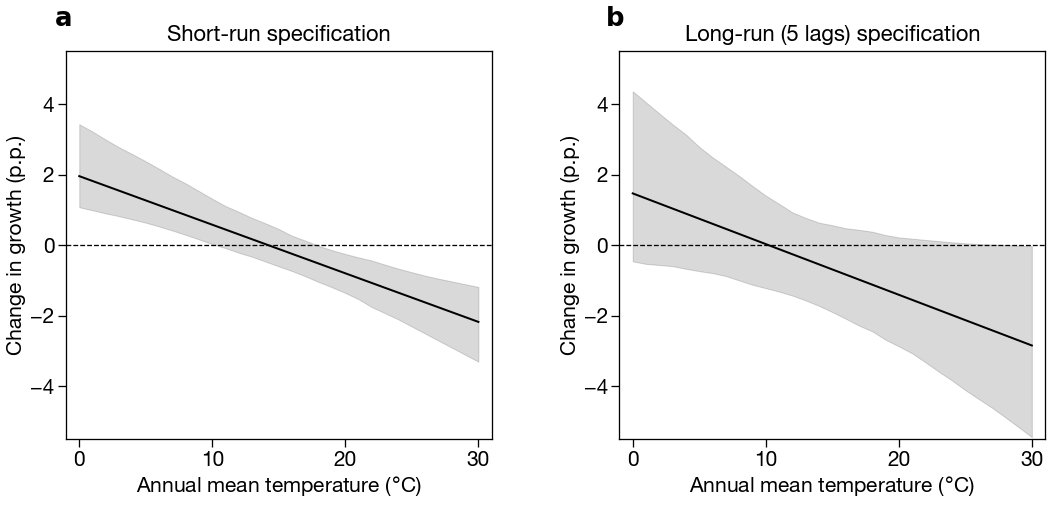

In [25]:
fig = plt.figure(figsize=(17,7))

rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 21.0
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3

tfs = 22

gs2 = gridspec.GridSpec(1,2)
gs2.update(left=0.12,right=0.92,top=0.89,bottom=0.12,wspace=0.3,hspace=0.33)

for j in [0,1]:
    if j == 0:
        mn = me_sr_mean
        upper = me_sr_upper
        lower = me_sr_lower
    else:
        mn = me_lr_mean
        upper = me_lr_upper
        lower = me_lr_lower
        
    ax = plt.subplot(gs2[0,j])
    plt.setp(ax.spines.values(), linewidth=1.3)

    plt.plot(t_x,mn,color="black",linewidth=2)
    ax.fill_between(t_x,lower,upper,
                   color="black",alpha=0.15)

    plt.axhline(y=0,linewidth=1.3,color="black",
               linestyle="--")
    plt.xlim([-1,31])
    plt.ylim([-5.5,5.5])
    plt.xlabel("Annual mean temperature ($\degree$C)")
    plt.ylabel("Change in growth (p.p.)")
    
    if j == 0:
        plt.title("Short-run specification",fontsize=tfs,pad=10)
    else:
        plt.title("Long-run ("+str(lr_lag_length)+" lags) specification",fontsize=tfs,pad=10)
        
plt.figtext(0.11,0.94,r'$\bf{a}$',fontsize=26)
plt.figtext(0.56,0.94,r'$\bf{b}$',fontsize=26)

plt.savefig("../Figures/FigX_ShortRun_LongRun_Effects.pdf")
plt.show()

Rich vs. poor marginal effects

In [26]:
coefs_rp = pd.read_csv(loc_damagefunc+"Attribution_Coefficients_Bootstrap_BHMRP.csv",index_col=0)
main_coefs = pd.read_csv(loc_damagefunc+"Attribution_Coefficients_Bootstrap_BHMSR.csv",index_col=0)

In [27]:
t_x = np.arange(0,30+1,1)
me_r = np.zeros((len(t_x),nboot))
me_p = np.zeros((len(t_x),nboot))
for j in np.arange(0,nboot,1):
    me_r[:,j] = coefs_rp.coef_t_rich.values[j] + t_x*2*coefs_rp.coef_t2_rich.values[j]
    me_p[:,j] = coefs_rp.coef_t_poor.values[j] + t_x*2*coefs_rp.coef_t2_poor.values[j]
me_r_mean = np.mean(me_r,axis=1)*100
me_r_upper = np.percentile(me_r,97.5,axis=1)*100
me_r_lower = np.percentile(me_r,2.5,axis=1)*100
me_p_mean = np.mean(me_p,axis=1)*100
me_p_upper = np.percentile(me_p,97.5,axis=1)*100
me_p_lower = np.percentile(me_p,2.5,axis=1)*100

In [28]:
me_orig = np.zeros((len(t_x),nboot))
for j in np.arange(0,nboot,1):
    me_orig[:,j] = main_coefs.coef_t.values[j] + t_x*2*main_coefs.coef_t2.values[j]
me_orig_mean = np.mean(me_orig,axis=1)*100

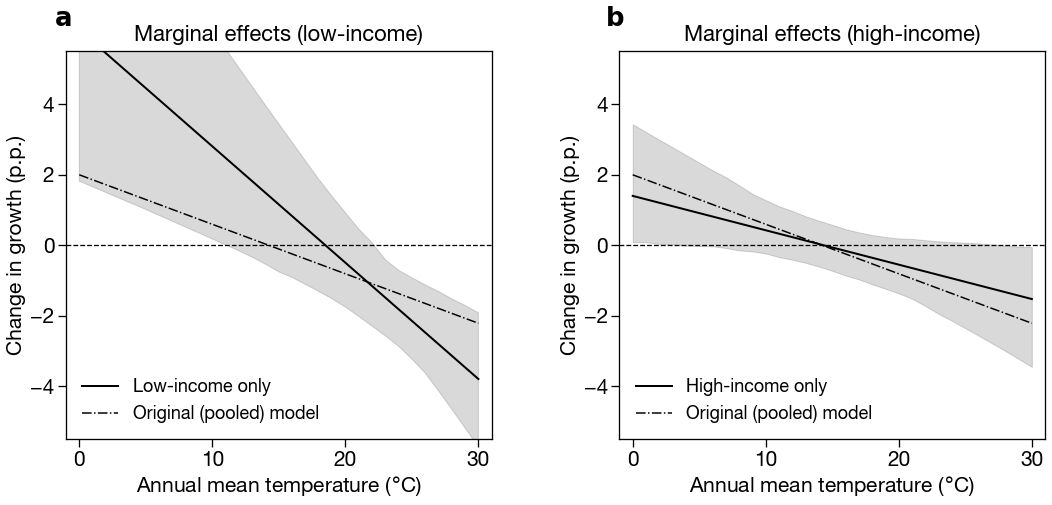

In [29]:
fig = plt.figure(figsize=(17,7))

rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 21.0
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3

tfs = 22

gs2 = gridspec.GridSpec(1,2)
gs2.update(left=0.12,right=0.92,top=0.89,bottom=0.12,wspace=0.3,hspace=0.33)

for j in [0,1]:
    if j == 0:
        mn = me_p_mean
        upper = me_p_upper
        lower = me_p_lower
        lb = "Low-income only"
    else:
        mn = me_r_mean
        upper = me_r_upper
        lower = me_r_lower
        lb = "High-income only"
        
    ax = plt.subplot(gs2[0,j])
    plt.setp(ax.spines.values(), linewidth=1.3)

    plt.plot(t_x,mn,color="black",linewidth=2,
            label=lb)
    ax.fill_between(t_x,lower,upper,
                   color="black",alpha=0.15)
    plt.plot(t_x,me_orig_mean,color="black",linewidth=1.5,
            linestyle="-.",label="Original (pooled) model")
    
    plt.axhline(y=0,linewidth=1.3,color="black",
               linestyle="--")
    plt.xlim([-1,31])
    plt.ylim([-5.5,5.5])
    plt.xlabel("Annual mean temperature ($\degree$C)")
    plt.ylabel("Change in growth (p.p.)")
    
    if j == 0:
        plt.title("Marginal effects (low-income)",fontsize=tfs,pad=10)
    else:
        plt.title("Marginal effects (high-income)",fontsize=tfs,pad=10)
        
    plt.legend(loc="lower left",fontsize=18,frameon=False)

plt.figtext(0.11,0.94,r'$\bf{a}$',fontsize=26)
plt.figtext(0.56,0.94,r'$\bf{b}$',fontsize=26)

plt.savefig("../Figures/FigX_Rich_Poor_Effects.pdf")
plt.show()

Now comparing damages from pooled vs rich-poor model

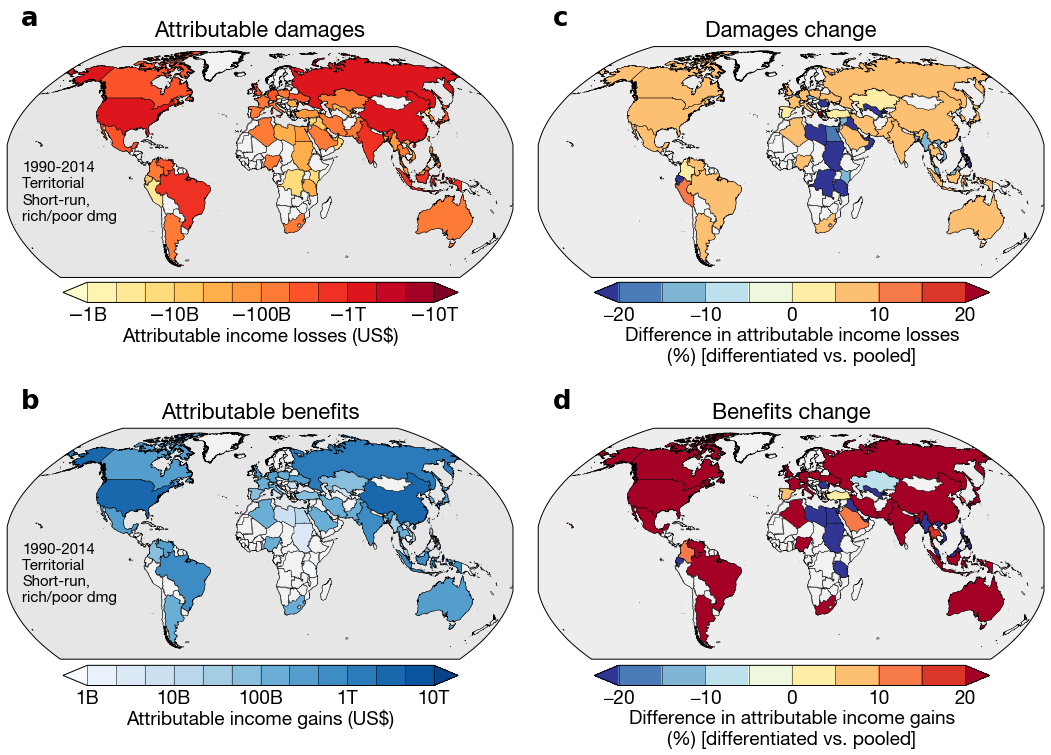

In [22]:
fig = plt.figure(figsize=(18,14))

rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 19.0

gs1 = gridspec.GridSpec(2,2)
gs1.update(left=0.1,right=0.9,top=0.9,bottom=0.23,wspace=0.05,hspace=0.3)

tfs = 22

# colorbar positions
left = [0.143,0.553]
bottom1 = 0.615
bottom2 = 0.235
width = 0.305
height = 0.02
tks = [1e9,1e10,1e11,1e12,1e13]
lbs1 = [r"$\rm{-}$1B",r"$\rm{-}$10B",r"$\rm{-}$100B",\
        r"$\rm{-}$1T",r"$\rm{-}$10T"]
lbs2 = ["1B","10B","100B","1T","10T"]

# damage specification info
accounting_loop = ["territorial","territorial"]
y1_loop = [1990,1990]
y2 = 2014
#titles = ["Net damages","Net damages","Net damages"]
damagefunc_loop = ["BHMRP","BHMRP"]


# details for maps of damages changes
#change_ext = ["both"]
#change_min = [-]
#change_max = [20,500]
#change_ncol = [9,11]
#change_maps = ["RdYlBu_r","YlOrRd"]


# loop through accounting/y1/etc.
for j in np.arange(0,len(accounting_loop),1):
    if j == 0:
        rcParams["axes.linewidth"] = 1
        rcParams['xtick.major.size'] = 4
        rcParams['xtick.major.width'] = 1
        rcParams['ytick.major.size'] = 4
        rcParams['ytick.major.width'] = 1
        
        fname_str = damagefunc_loop[j]+"_"+accounting_loop[j]+"_shares"+str(y1_loop[j])+"-"+str(y2)+"_"+str(y1_loop[j])+"-"+str(y2)
        damages_processed = xr.open_dataset(loc_damages_processed+"global_attributable_benefits_losses_"+fname_str+".nc")
        attr_benefits = damages_processed.attributable_benefits.sum(dim="time")
        attr_losses = damages_processed.attributable_losses.sum(dim="time")*-1
        
        # losses
        ax = plt.subplot(gs1[0,0],projection=ccrs.Robinson())
        vmin = 1e9
        vmax = 1e13
        ncol = 13
        bounds = np.linspace(vmin,vmax,ncol)

        cols = plt.get_cmap('YlOrRd')(np.linspace(0,1,len(bounds)+1))
        cm = colors.ListedColormap(cols[1:-1])
        cm.set_over(cols[-1])
        cm.set_under(cols[0])
        norm = colors.SymLogNorm(linthresh=1e3,vmin=vmin,vmax=vmax)
        cbar = plt.cm.ScalarMappable(norm=norm,cmap=cm)
    
        plt.setp(ax.spines.values(), linewidth=1)
        ax.set_extent([-180,180,-63,90],crs=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.5)
        ax.add_feature(cart.feature.OCEAN, edgecolor="white",facecolor=[0.9,0.9,0.9])
        
        # add colors/geoms
        add_attr_geometries(attr_losses,iso_shp,attr_losses.iso_attr.values,shp,"ISO3",cbar)
        
        plt.title("Attributable damages",fontsize=tfs,pad=10)
        
        if damagefunc_loop[j] == "BHMSR":
            funcstr = "Short-run dmg"
        elif damagefunc_loop[j] == "BHMLR":
            funcstr = "Long-run dmg"
        elif damagefunc_loop[j] == "BHMRP":
            funcstr = "Short-run,"+"\n"+"rich/poor dmg"
        st = str(y1_loop[j])+"-"+str(y2)+"\n"+accounting_loop[j].title()+"\n"+funcstr
        plt.text(0.03,0.25,st,ha="left",fontsize=15,
                transform=ax.transAxes)
        
        # colorbar
        cbar_ax = fig.add_axes([left[j], bottom1, width, height])
        cb = fig.colorbar(cbar,cax=cbar_ax,orientation='horizontal',drawedges=True,
                          extend="both",ticks=tks,extendfrac=0.07)
        cbar_ax.tick_params(direction="in",width=0.05)
        cb.ax.set_xticklabels(lbs1)
        cb.set_label("Attributable income losses (US$)",labelpad=2)
        
        
        # benefits
        ax = plt.subplot(gs1[1,0],projection=ccrs.Robinson())
        
        ncol = 14
        bounds = np.linspace(vmin,vmax,ncol)
        cols = plt.get_cmap('Blues')(np.linspace(0,1,len(bounds)+1))
        cm = colors.ListedColormap(cols[1:-2])
        cm.set_over(cols[-2])
        cm.set_under(cols[0])
        norm = colors.SymLogNorm(linthresh=1e3,vmin=vmin,vmax=vmax)
        cbar = plt.cm.ScalarMappable(norm=norm,cmap=cm)
        
        plt.setp(ax.spines.values(), linewidth=1)
        ax.set_extent([-180,180,-63,90],crs=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.5)
        ax.add_feature(cart.feature.OCEAN, edgecolor="white",facecolor=[0.9,0.9,0.9])

        # add colors/geoms
        add_attr_geometries(attr_benefits,iso_shp,attr_benefits.iso_attr.values,shp,"ISO3",cbar)
        
        plt.title("Attributable benefits",fontsize=tfs,pad=10)
        
        if damagefunc_loop[j] == "BHMSR":
            funcstr = "Short-run dmg"
        elif damagefunc_loop[j] == "BHMLR":
            funcstr = "Long-run dmg"
        elif damagefunc_loop[j] == "BHMRP":
            functr = "Short-run,"+"\n"+"rich/poor dmg"
        st = str(y1_loop[j])+"-"+str(y2)+"\n"+accounting_loop[j].title()+"\n"+funcstr
        plt.text(0.03,0.25,st,ha="left",fontsize=15,
                transform=ax.transAxes)
        
        # colorbar
        cbar_ax = fig.add_axes([left[j], bottom2, width, height])
        cb = fig.colorbar(cbar,cax=cbar_ax,orientation='horizontal',drawedges=True,
                          extend="both",ticks=tks,extendfrac=0.07)
        cbar_ax.tick_params(direction="in",width=0.05)
        cb.ax.set_xticklabels(lbs2)
        cb.set_label("Attributable income gains (US$)",labelpad=2)
        
        
    else:
        # damages and benefits change 
        
        fname_str = damagefunc_loop[j]+"_"+accounting_loop[j]+"_shares"+str(y1_loop[j])+"-"+str(y2)+"_"+str(y1_loop[j])+"-"+str(y2)
        fname_str_orig = "BHMSR_territorial_shares"+str(y1_loop[0])+"-"+str(y2)+"_"+str(y1_loop[0])+"-"+str(y2)
        damages_processed = xr.open_dataset(loc_damages_processed+"global_attributable_benefits_losses_"+fname_str+".nc")
        attr_losses = damages_processed.attributable_losses.sum(dim="time")
        attr_benefits = damages_processed.attributable_benefits.sum(dim="time")
        damages_processed_orig = xr.open_dataset(loc_damages_processed+"global_attributable_benefits_losses_"+fname_str_orig+".nc")
        attr_losses_orig = damages_processed_orig.attributable_losses.sum(dim="time")
        attr_benefits_orig = damages_processed_orig.attributable_benefits.sum(dim="time")
        attr_damages_change1 = 100*(attr_losses - attr_losses_orig)/attr_losses_orig
        attr_benefits_change1 = 100*(attr_benefits - attr_benefits_orig)/attr_benefits_orig
        attr_damages_change = attr_damages_change1.where(~np.isinf(np.abs(attr_damages_change1)),0.0)
        attr_benefits_change = attr_benefits_change1.where(~np.isinf(np.abs(attr_benefits_change1)),0.0)
        if accounting_loop[j]=="consumption":
            benefits_chng = attr_benefits_change
            loss_chng = attr_damages_change
            
        # damages change
        ax = plt.subplot(gs1[0,j],projection=ccrs.Robinson())
        
        plt.setp(ax.spines.values(), linewidth=1)
        ax.set_extent([-180,180,-63,90],crs=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.5)
        ax.add_feature(cart.feature.OCEAN, edgecolor="white",facecolor=[0.93,0.93,0.93])
        
        # colorbar
        vmin = -20
        vmax = 20
        ncol = 9
        bounds = np.linspace(vmin,vmax,ncol)

        cols = plt.get_cmap("RdYlBu_r")(np.linspace(0,1,len(bounds)+1))
        cm = colors.ListedColormap(cols[1:-1])
        cm.set_over(cols[-1])
        cm.set_under(cols[0])
        norm = colors.Normalize(vmin=vmin,vmax=vmax)
        cbar = plt.cm.ScalarMappable(norm=norm,cmap=cm)   
        
        add_attr_geometries(attr_damages_change,iso_shp,attr_damages_change.iso_attr.values,shp,"ISO3",cbar)
        
        
        plt.title("Damages change",fontsize=tfs,pad=10)
        
        #if j == 1:
        #    st = "Consumption"+"\n"+"vs."+"\n"+"territorial"
        #elif j == 2:
        #    st = "1960-2014"+"\n"+"vs."+"\n"+"1990-2014"
        #plt.text(0.12,0.25,st,ha="center",fontsize=15,
        #        transform=ax.transAxes)
    
        cbar_ax = fig.add_axes([left[j], bottom1, width, height])
        cb = fig.colorbar(cbar,cax=cbar_ax,orientation='horizontal',drawedges=True,
                          extend="both",extendfrac=0.07)
        cbar_ax.tick_params(direction="in",width=0.05)
        cb.set_label("Difference in attributable income losses"+"\n"+"(%) [differentiated vs. pooled]",
                    labelpad=2)
        
        
        # benefits change
        
        ax = plt.subplot(gs1[1,j],projection=ccrs.Robinson())
        plt.setp(ax.spines.values(), linewidth=1)
        ax.set_extent([-180,180,-63,90],crs=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.5)
        ax.add_feature(cart.feature.OCEAN, edgecolor="white",facecolor=[0.93,0.93,0.93])
        
        add_attr_geometries(attr_benefits_change,iso_shp,attr_benefits_change.iso_attr.values,shp,"ISO3",cbar)
            
        plt.title("Benefits change",fontsize=tfs,pad=10)
        
        #if j == 1:
        #    st = "Consumption"+"\n"+"vs."+"\n"+"territorial"
        #elif j == 2:
        #    st = "1960-2014"+"\n"+"vs."+"\n"+"1990-2014"
        #plt.text(0.12,0.25,st,ha="center",fontsize=15,
        #        transform=ax.transAxes)
        
        cbar_ax = fig.add_axes([left[j], bottom2, width, height])
        cb = fig.colorbar(cbar,cax=cbar_ax,orientation='horizontal',drawedges=True,
                          extend="both",extendfrac=0.07)
        cbar_ax.tick_params(direction="in",width=0.05)
        cb.set_label("Difference in attributable income gains"+"\n"+"(%) [differentiated vs. pooled]",
                    labelpad=2)
        
plt.figtext(0.11,0.89,r'$\bf{a}$',fontsize=26)
plt.figtext(0.11,0.51,r'$\bf{b}$',fontsize=26)
plt.figtext(0.52,0.89,r'$\bf{c}$',fontsize=26)
plt.figtext(0.52,0.51,r'$\bf{d}$',fontsize=26)
        
plt.savefig("../Figures/FigX_BHMRP_Damages.png")
plt.show()

Now uncertainty partitioning with the new damage functions

0
<xarray.DataArray ()>
array(3.08111704)
<xarray.DataArray ()>
array(72.83758371)
<xarray.DataArray ()>
array(2.63802758)
<xarray.DataArray ()>
array(21.44327167)
1
<xarray.DataArray ()>
array(0.67961592)
<xarray.DataArray ()>
array(17.1179219)
<xarray.DataArray ()>
array(0.78619287)
<xarray.DataArray ()>
array(81.41626931)


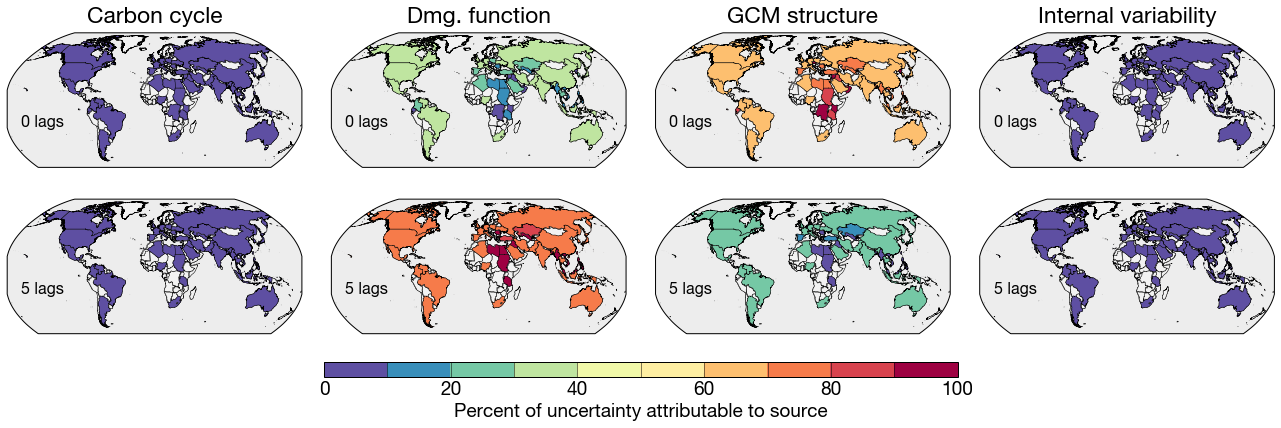

In [6]:
fig = plt.figure(figsize=(22,7))

rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 19.0
rcParams["axes.linewidth"] = 1
rcParams['xtick.major.size'] = 4
rcParams['xtick.major.width'] = 1
rcParams['ytick.major.size'] = 4
rcParams['ytick.major.width'] = 1

gs1 = gridspec.GridSpec(2,4)
gs1.update(left=0.1,right=0.9,top=0.9,bottom=0.27,wspace=0.1,hspace=0.1)


acc_loop = ["territorial","territorial"]
y1_loop = [1990,1990]
y2_shares = 2014
y2_damages = 2014
damagefunc_loop = ["BHMSR","BHMLR"]

benefits_or_damages = "benefits"
for j in np.arange(0,len(acc_loop),1):
    
    damagefunc = damagefunc_loop[j]
    acc = acc_loop[j]
    y1 = y1_loop[j]
    
    print(j)
    
    fname = loc_damages_processed+"global_attributable_benefits_losses_uncertainty_"+damagefunc+"_"+acc+"_shares"+str(y1)+"-"+str(y2_shares)+"_"+str(y1)+"-"+str(y2_damages)+".nc"
    if benefits_or_damages=="damages":
        sd_iv = xr.open_dataset(fname).damages_sd_iv
        sd_esm = xr.open_dataset(fname).damages_sd_mdl
        sd_carbon = xr.open_dataset(fname).damages_sd_fair
        sd_boot = xr.open_dataset(fname).damages_sd_boot
    elif benefits_or_damages=="benefits":
        sd_iv = xr.open_dataset(fname).benefits_sd_iv
        sd_esm = xr.open_dataset(fname).benefits_sd_mdl
        sd_carbon = xr.open_dataset(fname).benefits_sd_fair
        sd_boot = xr.open_dataset(fname).benefits_sd_boot
        
    var_iv = sd_iv**2
    var_esm = sd_esm**2
    var_carbon = sd_carbon**2
    var_boot = sd_boot**2
    var_total = var_iv + var_esm + var_carbon + var_boot

    var_pct_iv = (var_iv/var_total)*100
    var_pct_esm = (var_esm/var_total)*100
    var_pct_carbon = (var_carbon/var_total)*100
    var_pct_boot = (var_boot/var_total)*100
    nms = ["Carbon cycle","Dmg. function","GCM structure","Internal variability"]
    
    vmin = 0
    vmax = 100
    norm = colors.Normalize(vmin=vmin,vmax=vmax) 
    ncol = 10
    cmap = "Spectral_r"
    cbar = plt.cm.ScalarMappable(norm=norm,cmap=plt.cm.get_cmap(cmap,(ncol)))
    
    print(var_pct_iv.mean())
    print(var_pct_esm.mean())
    print(var_pct_carbon.mean())
    print(var_pct_boot.mean())
    
    if j == 0:
        var_pct_iv_bhmsr = var_pct_iv
        var_pct_mdl_bhmsr = var_pct_esm
        var_pct_carbon_bhmsr = var_pct_carbon
        var_pct_boot_bhmsr = var_pct_boot
    else:
        var_pct_iv_bhmlr = var_pct_iv
        var_pct_mdl_bhmlr = var_pct_esm
        var_pct_carbon_bhmlr = var_pct_carbon
        var_pct_boot_bhmlr = var_pct_boot
        
    for k in np.arange(0,4,1):
        if k == 0:
            pct = var_pct_carbon
        elif k == 1:
            pct = var_pct_boot
        elif k == 2:
            pct = var_pct_esm
        elif k == 3:
            pct = var_pct_iv
            
        ax = plt.subplot(gs1[j,k],projection=ccrs.Robinson())

        plt.setp(ax.spines.values(), linewidth=1)
        ax.set_extent([-180,180,-63,90],crs=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.5)
        ax.add_feature(cart.feature.OCEAN, edgecolor="white",facecolor=[0.93,0.93,0.93])

        for i in iso_shp:
            if i in pct.coords["iso_attr"].values:
                val = pct.loc[i].values
                if ~np.isnan(val):
                    ax.add_geometries(shp.loc[shp["ISO3"].values==i,"geometry"],ccrs.PlateCarree(),
                                              facecolor=cbar.to_rgba(val),edgecolor="black",linewidth=0.5,zorder=10)
                else:
                    ax.add_geometries(shp.loc[shp["ISO3"].values==i,"geometry"],ccrs.PlateCarree(),
                                              facecolor=[0.95,0.95,0.95],edgecolor="black",linewidth=0.5)
            else:
                ax.add_geometries(shp.loc[shp["ISO3"].values==i,"geometry"],ccrs.PlateCarree(),
                                          facecolor=[0.95,0.95,0.95],edgecolor="black",linewidth=0.5)
        
        if j == 0:
            plt.title(nms[k],pad=10)
            txt = "0 lags"
        elif j == 1:
            txt = "5 lags"
            
        plt.text(0.12,0.3,txt,ha="center",fontsize=16,
            transform=ax.transAxes,)
        
cbar_ax = fig.add_axes([0.3,0.2,0.4,0.03])
cb = fig.colorbar(cbar,cax=cbar_ax,orientation='horizontal',
                  drawedges=True,extend="neither")
cbar_ax.tick_params(direction="in",width=0.05)
#cb.ax.set_xticklabels(lbs1)
cb.set_label("Percent of uncertainty attributable to source")


plt.savefig("../Figures/FigX_Uncertainty_Partition_"+benefits_or_damages.title()+".png")
plt.show()

Damages using a t-test instead of a ks-test

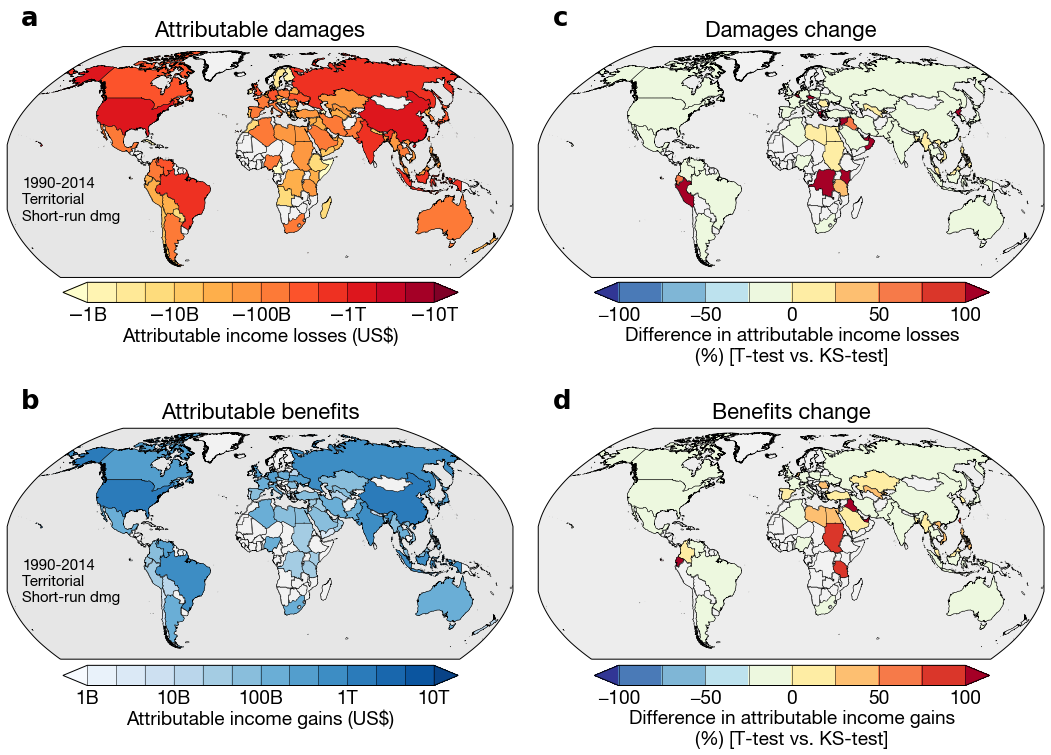

In [7]:
fig = plt.figure(figsize=(18,14))

rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 19.0

gs1 = gridspec.GridSpec(2,2)
gs1.update(left=0.1,right=0.9,top=0.9,bottom=0.23,wspace=0.05,hspace=0.3)

tfs = 22

# colorbar positions
left = [0.143,0.553]
bottom1 = 0.615
bottom2 = 0.235
width = 0.305
height = 0.02
tks = [1e9,1e10,1e11,1e12,1e13]
lbs1 = [r"$\rm{-}$1B",r"$\rm{-}$10B",r"$\rm{-}$100B",\
        r"$\rm{-}$1T",r"$\rm{-}$10T"]
lbs2 = ["1B","10B","100B","1T","10T"]

# details for maps of damages changes
#change_ext = ["both"]
#change_min = [-]
#change_max = [20,500]
#change_ncol = [9,11]
#change_maps = ["RdYlBu_r","YlOrRd"]

accounting_loop = ["territorial","territorial"]
y1_loop = [1990,1990]
y2 = 2014
#titles = ["Net damages","Net damages","Net damages"]
damagefunc_loop = ["BHMSR","BHMSR"]


# loop through accounting/y1/etc.
for j in np.arange(0,len(accounting_loop),1):
    if j == 0:
        rcParams["axes.linewidth"] = 1
        rcParams['xtick.major.size'] = 4
        rcParams['xtick.major.width'] = 1
        rcParams['ytick.major.size'] = 4
        rcParams['ytick.major.width'] = 1
        
        fname_str = damagefunc_loop[j]+"_"+accounting_loop[j]+"_shares"+str(y1_loop[j])+"-"+str(y2)+"_"+str(y1_loop[j])+"-"+str(y2)
        damages_processed = xr.open_dataset(loc_damages_processed+"global_attributable_benefits_losses_"+fname_str+"_ttest.nc")
        attr_benefits = damages_processed.attributable_benefits.sum(dim="time")
        attr_losses = damages_processed.attributable_losses.sum(dim="time")*-1
        
        # losses
        ax = plt.subplot(gs1[0,0],projection=ccrs.Robinson())
        vmin = 1e9
        vmax = 1e13
        ncol = 13
        bounds = np.linspace(vmin,vmax,ncol)

        cols = plt.get_cmap('YlOrRd')(np.linspace(0,1,len(bounds)+1))
        cm = colors.ListedColormap(cols[1:-1])
        cm.set_over(cols[-1])
        cm.set_under(cols[0])
        norm = colors.SymLogNorm(linthresh=1e3,vmin=vmin,vmax=vmax)
        cbar = plt.cm.ScalarMappable(norm=norm,cmap=cm)
    
        plt.setp(ax.spines.values(), linewidth=1)
        ax.set_extent([-180,180,-63,90],crs=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.5)
        ax.add_feature(cart.feature.OCEAN, edgecolor="white",facecolor=[0.9,0.9,0.9])
        
        # add colors/geoms
        add_attr_geometries(attr_losses,iso_shp,attr_losses.iso_attr.values,shp,"ISO3",cbar)
        
        plt.title("Attributable damages",fontsize=tfs,pad=10)
        
        if damagefunc_loop[j] == "BHMSR":
            funcstr = "Short-run dmg"
        elif damagefunc_loop[j] == "BHMLR":
            funcstr = "Long-run dmg"
        st = str(y1_loop[j])+"-"+str(y2)+"\n"+accounting_loop[j].title()+"\n"+funcstr
        plt.text(0.03,0.25,st,ha="left",fontsize=15,
                transform=ax.transAxes)
        
        # colorbar
        cbar_ax = fig.add_axes([left[j], bottom1, width, height])
        cb = fig.colorbar(cbar,cax=cbar_ax,orientation='horizontal',drawedges=True,
                          extend="both",ticks=tks,extendfrac=0.07)
        cbar_ax.tick_params(direction="in",width=0.05)
        cb.ax.set_xticklabels(lbs1)
        cb.set_label("Attributable income losses (US$)",labelpad=2)
        
        
        # benefits
        ax = plt.subplot(gs1[1,0],projection=ccrs.Robinson())
        
        ncol = 14
        bounds = np.linspace(vmin,vmax,ncol)
        cols = plt.get_cmap('Blues')(np.linspace(0,1,len(bounds)+1))
        cm = colors.ListedColormap(cols[1:-2])
        cm.set_over(cols[-2])
        cm.set_under(cols[0])
        norm = colors.SymLogNorm(linthresh=1e3,vmin=vmin,vmax=vmax)
        cbar = plt.cm.ScalarMappable(norm=norm,cmap=cm)
        
        plt.setp(ax.spines.values(), linewidth=1)
        ax.set_extent([-180,180,-63,90],crs=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.5)
        ax.add_feature(cart.feature.OCEAN, edgecolor="white",facecolor=[0.9,0.9,0.9])

        # add colors/geoms
        add_attr_geometries(attr_benefits,iso_shp,attr_benefits.iso_attr.values,shp,"ISO3",cbar)
        
        plt.title("Attributable benefits",fontsize=tfs,pad=10)
        
        if damagefunc_loop[j] == "BHMSR":
            funcstr = "Short-run dmg"
        elif damagefunc_loop[j] == "BHMLR":
            funcstr = "Long-run dmg"
        st = str(y1_loop[j])+"-"+str(y2)+"\n"+accounting_loop[j].title()+"\n"+funcstr
        plt.text(0.03,0.25,st,ha="left",fontsize=15,
                transform=ax.transAxes)
        
        # colorbar
        cbar_ax = fig.add_axes([left[j], bottom2, width, height])
        cb = fig.colorbar(cbar,cax=cbar_ax,orientation='horizontal',drawedges=True,
                          extend="both",ticks=tks,extendfrac=0.07)
        cbar_ax.tick_params(direction="in",width=0.05)
        cb.ax.set_xticklabels(lbs2)
        cb.set_label("Attributable income gains (US$)",labelpad=2)
        
        
    else:
        # damages and benefits change 
        
        fname_str = damagefunc_loop[j]+"_"+accounting_loop[j]+"_shares"+str(y1_loop[j])+"-"+str(y2)+"_"+str(y1_loop[j])+"-"+str(y2)
        fname_str_orig = "BHMSR_territorial_shares"+str(y1_loop[0])+"-"+str(y2)+"_"+str(y1_loop[0])+"-"+str(y2)
        damages_processed = xr.open_dataset(loc_damages_processed+"global_attributable_benefits_losses_"+fname_str+"_ttest.nc")
        attr_losses = damages_processed.attributable_losses.sum(dim="time")
        attr_benefits = damages_processed.attributable_benefits.sum(dim="time")
        damages_processed_orig = xr.open_dataset(loc_damages_processed+"global_attributable_benefits_losses_"+fname_str_orig+".nc")
        attr_losses_orig = damages_processed_orig.attributable_losses.sum(dim="time")
        attr_benefits_orig = damages_processed_orig.attributable_benefits.sum(dim="time")
        attr_damages_change1 = 100*(attr_losses - attr_losses_orig)/attr_losses_orig
        attr_benefits_change1 = 100*(attr_benefits - attr_benefits_orig)/attr_benefits_orig
        attr_damages_change = attr_damages_change1.where(~np.isinf(np.abs(attr_damages_change1)),0.0)
        attr_benefits_change = attr_benefits_change1.where(~np.isinf(np.abs(attr_benefits_change1)),0.0)
        if accounting_loop[j]=="consumption":
            benefits_chng = attr_benefits_change
            loss_chng = attr_damages_change
            
        # damages change
        ax = plt.subplot(gs1[0,j],projection=ccrs.Robinson())
        
        plt.setp(ax.spines.values(), linewidth=1)
        ax.set_extent([-180,180,-63,90],crs=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.5)
        ax.add_feature(cart.feature.OCEAN, edgecolor="white",facecolor=[0.93,0.93,0.93])
        
        # colorbar
        vmin = -100
        vmax = 100
        ncol = 9
        bounds = np.linspace(vmin,vmax,ncol)

        cols = plt.get_cmap("RdYlBu_r")(np.linspace(0,1,len(bounds)+1))
        cm = colors.ListedColormap(cols[1:-1])
        cm.set_over(cols[-1])
        cm.set_under(cols[0])
        norm = colors.Normalize(vmin=vmin,vmax=vmax)
        cbar = plt.cm.ScalarMappable(norm=norm,cmap=cm)   
        
        add_attr_geometries(attr_damages_change,iso_shp,attr_damages_change.iso_attr.values,shp,"ISO3",cbar)
        
        
        plt.title("Damages change",fontsize=tfs,pad=10)
        
        #if j == 1:
        #    st = "Consumption"+"\n"+"vs."+"\n"+"territorial"
        #elif j == 2:
        #    st = "1960-2014"+"\n"+"vs."+"\n"+"1990-2014"
        #plt.text(0.12,0.25,st,ha="center",fontsize=15,
        #        transform=ax.transAxes)
    
        cbar_ax = fig.add_axes([left[j], bottom1, width, height])
        cb = fig.colorbar(cbar,cax=cbar_ax,orientation='horizontal',drawedges=True,
                          extend="both",extendfrac=0.07)
        cbar_ax.tick_params(direction="in",width=0.05)
        cb.set_label("Difference in attributable income losses"+"\n"+"(%) [T-test vs. KS-test]",
                    labelpad=2)
        
        
        # benefits change
        
        ax = plt.subplot(gs1[1,j],projection=ccrs.Robinson())
        plt.setp(ax.spines.values(), linewidth=1)
        ax.set_extent([-180,180,-63,90],crs=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.5)
        ax.add_feature(cart.feature.OCEAN, edgecolor="white",facecolor=[0.93,0.93,0.93])
        
        add_attr_geometries(attr_benefits_change,iso_shp,attr_benefits_change.iso_attr.values,shp,"ISO3",cbar)
            
        plt.title("Benefits change",fontsize=tfs,pad=10)
        
        #if j == 1:
        #    st = "Consumption"+"\n"+"vs."+"\n"+"territorial"
        #elif j == 2:
        #    st = "1960-2014"+"\n"+"vs."+"\n"+"1990-2014"
        #plt.text(0.12,0.25,st,ha="center",fontsize=15,
        #        transform=ax.transAxes)
        
        cbar_ax = fig.add_axes([left[j], bottom2, width, height])
        cb = fig.colorbar(cbar,cax=cbar_ax,orientation='horizontal',drawedges=True,
                          extend="both",extendfrac=0.07)
        cbar_ax.tick_params(direction="in",width=0.05)
        cb.set_label("Difference in attributable income gains"+"\n"+"(%) [T-test vs. KS-test]",
                    labelpad=2)
        
plt.figtext(0.11,0.89,r'$\bf{a}$',fontsize=26)
plt.figtext(0.11,0.51,r'$\bf{b}$',fontsize=26)
plt.figtext(0.52,0.89,r'$\bf{c}$',fontsize=26)
plt.figtext(0.52,0.51,r'$\bf{d}$',fontsize=26)
        
plt.savefig("../Figures/FigX_TTest.png")
plt.show()

Climate model GMST

In [41]:
models_cmip6 = ["ACCESS-CM2","ACCESS-ESM1-5","BCC-CSM2-MR","CanESM5",\
                 "CNRM-CM6-1","FGOALS-g3",\
                "GFDL-ESM4","HadGEM3-GC31-LL","IPSL-CM6A-LR",\
                  "MIROC6","MRI-ESM2-0","NorESM2-LM"]
nmodels_cmip6 = len(models_cmip6)
y1_in_cmip6 = 1850
y2_in_cmip6 = 2020

cesm1_sfle_runs = ["001","002","003","004","005","006",\
                    "007","008","009","010","011","012","013",\
                    "014","015","016","017","018","019","020"]
nruns = len(cesm1_sfle_runs)
y1_in_cesm = 1920
y2_in_cesm = 2020

# all ensemble members
ensembles = ["CMIP6","CESM1-SFLE"]
n_members = 20
num_members = [nmodels_cmip6,nruns]
members = np.arange(1,n_members+1,1)

In [42]:
y1_plot = 1960
y2_plot = 2014
years_plot = np.arange(y1_plot,y2_plot+1,1)
len_smooth_gmst = 11
len_smooth_ctry = 11
ctr = True

In [43]:
gmst_hist = xr.DataArray(np.full((len(ensembles),n_members,len(years_plot)),np.nan),
                     coords=[ensembles,members,years_plot],
                     dims=["ensemble","member","time"])
gmst_nat = xr.DataArray(np.full((len(ensembles),n_members,len(years_plot)),np.nan),
                     coords=[ensembles,members,years_plot],
                     dims=["ensemble","member","time"])


for mm in np.arange(0,nmodels_cmip6,1):
    m = models_cmip6[mm]
    gmst_in = xr.open_dataarray(loc_cmip6_hist_gmst+m+"_gmst_yr_historical_"+str(y1_in_cmip6)+"-"+str(y2_in_cmip6)+".nc")
    gmst_smooth = gmst_in.rolling(time=len_smooth_gmst,min_periods=len_smooth_gmst,center=ctr).mean()
    timeind = (gmst_smooth.time.dt.year>=y1_plot)&(gmst_smooth.time.dt.year<=y2_plot)
    gmst_hist[0,mm,:] = gmst_smooth[timeind].values
    
    gmst_nat_in = xr.open_dataarray(loc_cmip6_histnat_gmst+m+"_gmst_yr_historical-nat_"+str(y1_in_cmip6)+"-"+str(y2_in_cmip6)+".nc")
    gmst_nat_smooth = gmst_nat_in.rolling(time=len_smooth_gmst,min_periods=len_smooth_gmst,center=ctr).mean()
    timeind = (gmst_nat_smooth.time.dt.year>=y1_plot)&(gmst_nat_smooth.time.dt.year<=y2_plot)
    gmst_nat[0,mm,:] = gmst_nat_smooth[timeind].values

for rr in np.arange(0,nruns,1):
    r = cesm1_sfle_runs[rr]
    
    gmst_in = xr.open_dataarray(loc_cesm_hist_gmst+"CESM1-LE_"+r+"_gmst_yr_historical_"+str(y1_in_cesm)+"-"+str(y2_in_cesm)+".nc")
    gmst_smooth = gmst_in.rolling(time=len_smooth_gmst,min_periods=len_smooth_gmst,center=ctr).mean()
    timeind = (gmst_smooth.time.dt.year>=y1_plot)&(gmst_smooth.time.dt.year<=y2_plot)
    gmst_hist[1,rr,:] = gmst_smooth[timeind].values
    
    gmst_nat_in = xr.open_dataarray(loc_cesm_histnat_gmst+"CESM1-LE_"+r+"_gmst_yr_historical-nat_"+str(y1_in_cesm)+"-"+str(y2_in_cesm)+".nc")
    gmst_nat_smooth = gmst_nat_in.rolling(time=len_smooth_gmst,min_periods=len_smooth_gmst,center=ctr).mean()
    timeind = (gmst_nat_smooth.time.dt.year>=y1_plot)&(gmst_nat_smooth.time.dt.year<=y2_plot)
    gmst_nat[1,rr,:] = gmst_nat_smooth[timeind].values

In [44]:
gmst_diff = gmst_hist - gmst_nat

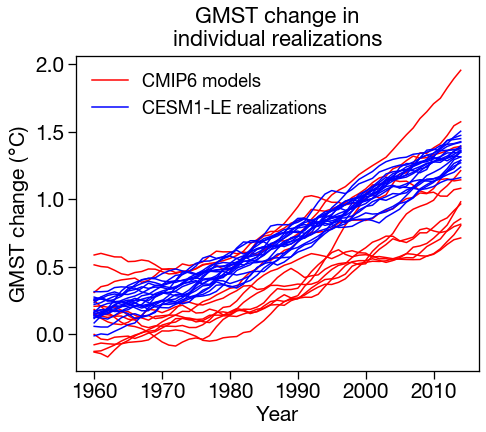

In [45]:
fig = plt.figure(figsize=(7,6))

rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 21.0
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3
rcParams["axes.linewidth"] = 1.3

tfs = 22

gs2 = gridspec.GridSpec(1,1)
gs2.update(left=0.14,right=0.94,top=0.87,bottom=0.14,wspace=0.3,hspace=0.33)

ax = plt.subplot(gs2[0,0])

cols = ["red","blue"]
ens = ["CMIP6","CESM1-LE"]
lbs = ["CMIP6 models","CESM1-LE realizations"]
for k in [0,1]:
    gmst_diff_k = gmst_diff[k,:,:]
    for x in np.arange(0,gmst_diff_k.shape[0],1):
        if x == 0:
            plt.plot(gmst_diff_k.time.values,gmst_diff_k[x,:],
                    color=cols[k],label=lbs[k])
        else:
            plt.plot(gmst_diff_k.time.values,gmst_diff_k[x,:],
                    color=cols[k])

plt.legend(loc="upper left",frameon=False,fontsize=18)
plt.xlabel("Year")
plt.ylabel("GMST change ($\degree$C)")
plt.title("GMST change in"+"\n"+"individual realizations",fontsize=tfs,pad=10)

plt.savefig("../Figures/FigX_GMST_Realizations.pdf")
plt.show()

Plot regression coefficients from multiple data sources

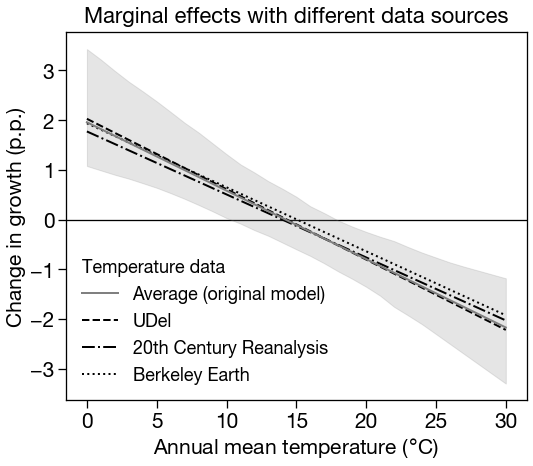

In [30]:
fig = plt.figure(figsize=(8,7))

rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 21.0
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3
rcParams["axes.linewidth"] = 1.3

tfs = 22

gs2 = gridspec.GridSpec(1,1)
gs2.update(left=0.14,right=0.94,top=0.87,bottom=0.14,wspace=0.3,hspace=0.33)

ax = plt.subplot(gs2[0,0])

coefs_orig = pd.read_csv(loc_damagefunc+"Attribution_TempCoefs_Bootstrap_Contemporaneous.csv",index_col=0)
boot = coefs_orig.boot.values
nboot = len(boot)

t_x = np.arange(0,30+1,1)
me = np.zeros((len(t_x),nboot))
for j in np.arange(0,nboot,1):
    me[:,j] = coefs_orig.coef_t.values[j] + t_x*2*coefs_orig.coef_t2.values[j]
me_mean = np.mean(me,axis=1)*100
me_upper = np.percentile(me,97.5,axis=1)*100
me_lower = np.percentile(me,2.5,axis=1)*100

plt.plot(t_x,me_mean,color="gray",linewidth=2,zorder=3,
        label="Average (original model)")
ax.fill_between(t_x,me_lower,me_upper,color="gray",alpha=0.2,zorder=2)

coefs_datasources = pd.read_csv(loc_damagefunc+"Attribution_Coefficients_Temp_Datasets.csv",index_col=0)
datasources = ["UDel","20cr","BEST"]
lbs = ["UDel","20th Century Reanalysis","Berkeley Earth"]
ls = ["--","-.",":"]
for k in np.arange(0,len(datasources),1):
    coef_t = coefs_datasources["coef_t_"+datasources[k]].values
    coef_t2 = coefs_datasources["coef_t2_"+datasources[k]].values
    me = (coef_t + t_x*2*coef_t2)*100
    plt.plot(t_x,me,linewidth=2,color="black",linestyle=ls[k],label=lbs[k])

plt.axhline(y=0,linewidth=1.3,color="black",linestyle="-",zorder=1)

lfs = 18
leg0 = plt.legend(loc="lower left",fontsize=lfs,
                  frameon=False,title="Temperature data")
leg0.get_title().set_fontsize(str(lfs))
leg0._legend_box.align = "left"

plt.xlabel("Annual mean temperature ($\degree$C)")
plt.ylabel("Change in growth (p.p.)")
plt.title("Marginal effects with different data sources",fontsize=22,pad=10)


plt.savefig("../Figures/FigX_Data_Source_Regressions.pdf")
plt.show()